# Homework 3

The deadline for this assignment is on Canvas. There are 18 points available for this notebook; another 2 points are automatically assigned by the autograder if you follow the below instructions.

This assignment can be completed in **groups of two**. If you need to find a partner, please post in the pinned note on Piazza.

Late work is accepted by editing the `LATE_DAYS` file. See `README.md` for more information.

## Academic Integrity

Once you have formed your groups, the work you submit must belong only to your group members. Do not submit another team's work as your own, and do not allow another team to submit your work as their own.

If you use resources you find online, you must cite those in your notebook. If we find sufficiently suspicious similarities between your answers and those of another group, all students involved may be reported for a suspected violation. If you're unsure of the academic integrity policies, ask for help; we can help you avoid breaking the rules, but we can't un-report a suspected violation.

By pushing your code to GitHub, you agree to these rules, and understand that there may be severe consequences for violating them.

## Important instructions

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw3.pdf printout of the completed notebook that shows all your answers.

* your final hw3.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output (almost) identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points.

In [1]:
import os
# This may be necessary to ensure torch can load deterministic algorithms
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Choose basedir as either local or hosted directory
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()

# get helper code from the course repository
# install common packages used for deep learning
%cd $base_dir
!git clone https://github.com/cs449f23/lectures.git lectures/
%cd $base_dir/lectures/
!git pull -q origin main
!pip install -q -r requirements.txt

/content
Cloning into 'lectures'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 222 (delta 103), reused 211 (delta 95), pack-reused 0
Receiving objects: 100% (222/222), 22.61 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/lectures
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/

In [2]:
%matplotlib inline

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

## GANs and Autoencoders

This homework assignment builds off the GAN notebook and the Autoencoder notebook that we saw in class. You may copy any code from those notebooks into your code.

For this assignment, you will combine the models introduced in those two notebooks to create a combined Autoencoder + GAN model. In particular, that will look something like this:

![Diagram of model architecture](https://github.com/cs449f23/lectures/raw/main/static/hw3_fig.png)

We're giving you the defined models below and the skeleton of the training code, and you just need to define the optimizers and write the loss functions to allow these models to train together.

If we write this in a functional representation, then the encoder $E(X)$ takes in a real image and outputs a $z$ vector, the generator $G(z)$ takes in a $z$ vector and outputs an image $\tilde X$, and the discriminator $D(X)$ takes in an image and outputs a scalar probability. $G(z)$ can either take in a $z$ sampled from a Gaussian distribution or produced by the encoder; we will evaluate your generation in both cases.

The autoencoder loss will be MSELoss comparing $X$ and $\tilde X$ and the generator and discriminator will be otherwise the same as in a GAN. The tricky component is to get the model to train and reduce all three losses simultaneously.

In [3]:
class MLPGenerator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPDiscriminator(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""

        super().__init__()

        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg

        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]

        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPEncoder(torch.nn.Module):

    def __init__(self,
                 number_of_hidden_layers: int,
                 input_size: int,
                 hidden_size: int,
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""

        super().__init__()

        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"

        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))

            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.net(x)


class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int,
                 latent_size: int,
                 hidden_size: int,
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):

        super().__init__()

        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            latent_size=latent_size,
            activation=activation_generator,
        )

        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=latent_size,
            hidden_size=hidden_size,
            output_size=output_size,
            activation=activation_generator
        )

        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers,
            input_size=output_size,
            hidden_size=hidden_size,
            activation=activation_discriminator
        )

In [4]:
# Don't change the image size.
image_size = 28
# You shouldn't *need* to change latent size, but you can if you want
latent_size = 64
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()
# autoencoder loss function: mean squared error between original and new image
autoencoder_loss_func = torch.nn.MSELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

## Coding Preliminaries (4 points)

You need to write code to get the model to train. There are a few design decisions you need to make; not all have a single correct answer. You **don't need to answer** these questions with written responses; just write your code. These questions are just guidance for how we will grade your code.

1. What are your loss functions?

  You will need to compute the loss of your model for each part of the model: `loss_discriminator`, `loss_generator`, and `loss_autoencoder`. You should look at the printout for these losses. Overall, we expect that each loss will decrease for at least *part* of the training time and the total loss should decrease monotonically.


2. How do you use optimizers to train your model?

  You will need to instantiate optimizer(s) from the `torch.nn.optim` module. You may want to more than one optimizer, so you can use different optimizers for different parts of your model. How many optimizers to use is up to you. Be sure to use `zero_grad()` to zero out gradients. You may want to use `detach()` as we did in the GAN notebook.


3. Can we reproduce your code?

  For full points, we must be able to run your notebook as is and reproduce (almost) exactly the same results.

In [78]:
# TODO: change these training hyperparameters

hidden_size = 256
number_of_hidden_layers = 2
epochs = 80
batch_size = 64
batch_limit = 1000

In [6]:
# Load MNIST dataset
# You only need to rerun this cell if you've changed `batch_size`
mnist = load_mnist(batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 87075752.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32165611.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24664905.09it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5631252.96it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch:    1  AE Loss:    0.121  Gen Loss:    3.299  Dis Loss:    0.474  Total:      3.9


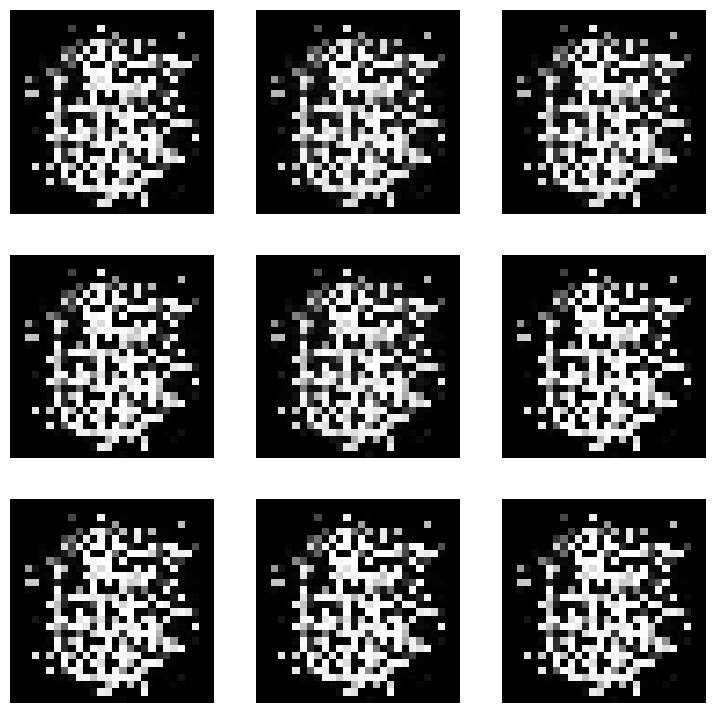

Epoch:    8  AE Loss:    0.067  Gen Loss:    5.212  Dis Loss:    0.196  Total:      5.5


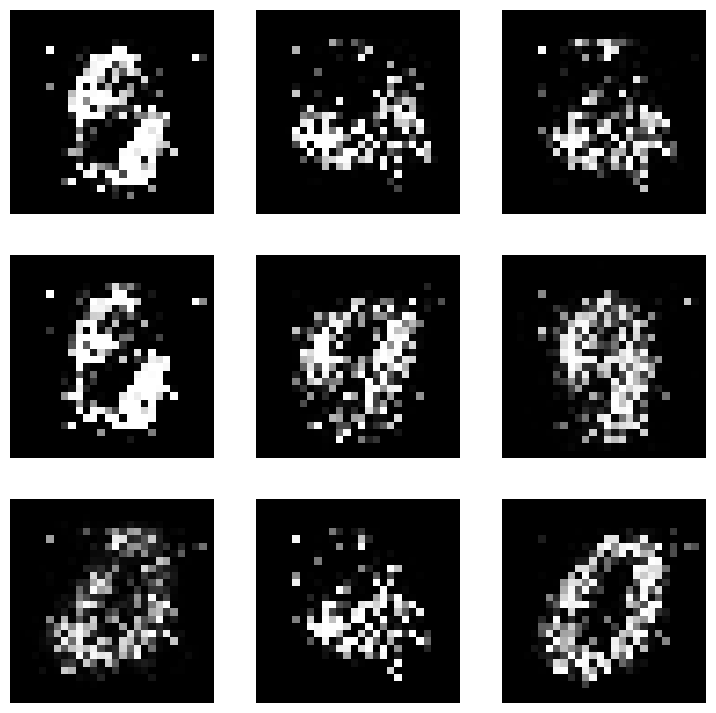

Epoch:   16  AE Loss:    0.047  Gen Loss:    2.330  Dis Loss:    0.695  Total:      3.1


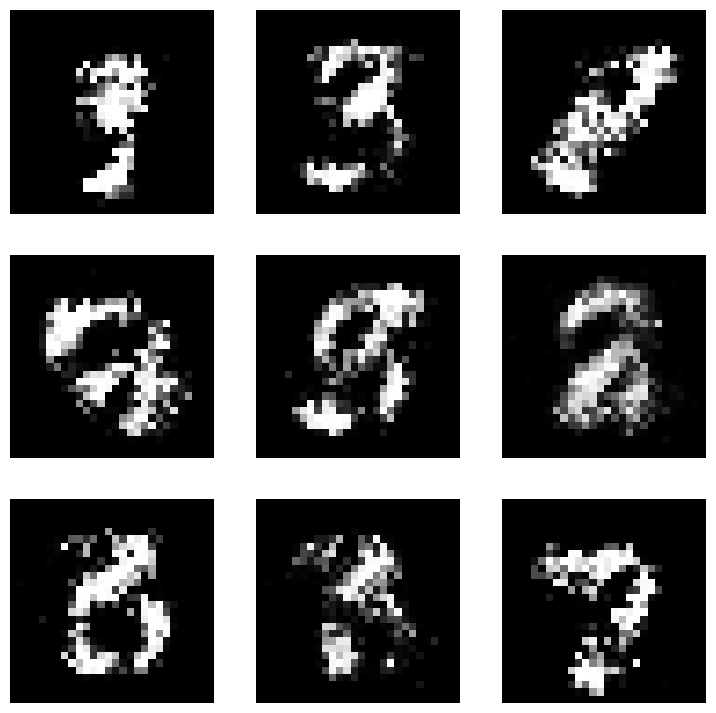

Epoch:   24  AE Loss:    0.033  Gen Loss:    1.291  Dis Loss:    1.064  Total:      2.4


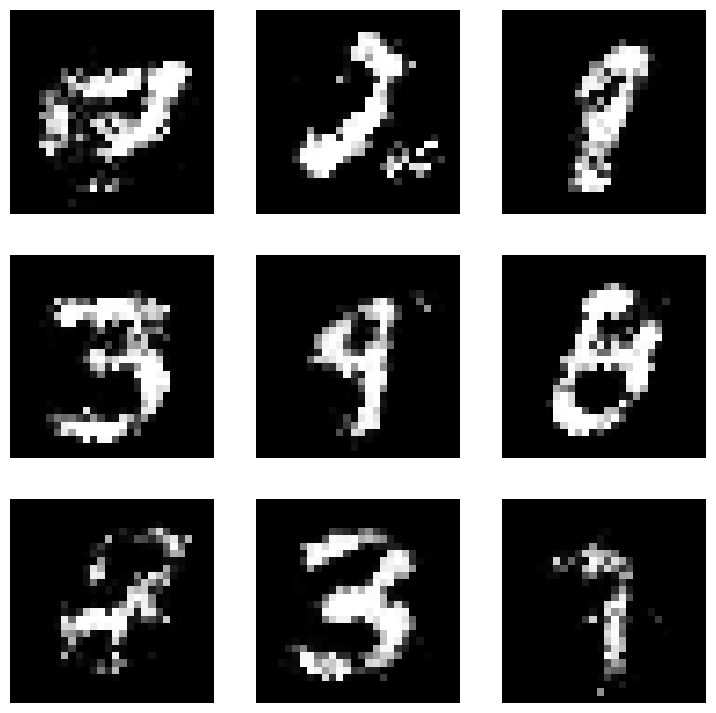

Epoch:   32  AE Loss:    0.028  Gen Loss:    1.099  Dis Loss:    1.155  Total:      2.3


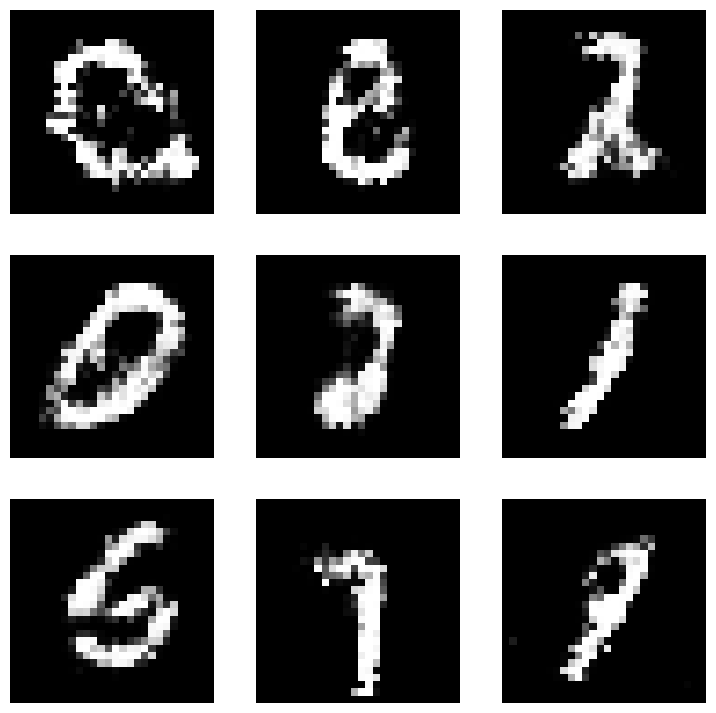

Epoch:   40  AE Loss:    0.024  Gen Loss:    1.068  Dis Loss:    1.181  Total:      2.3


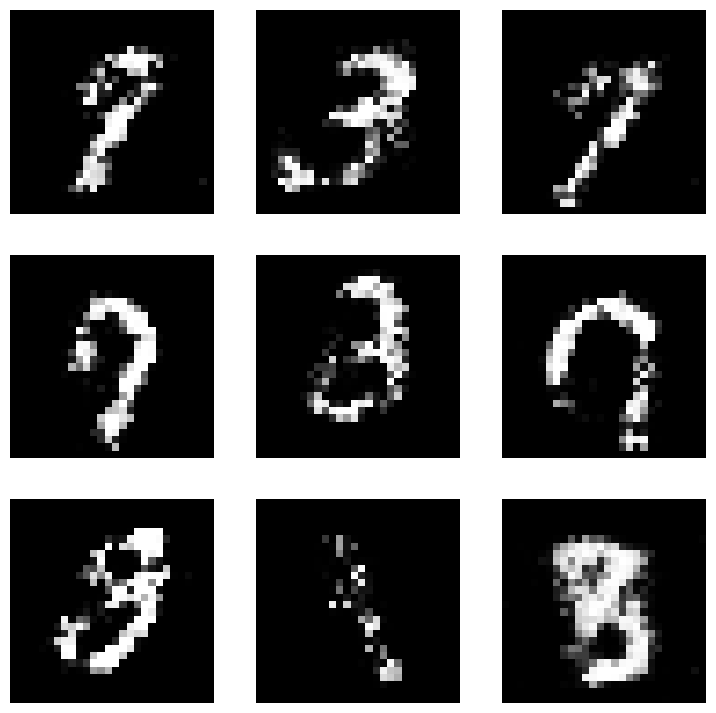

Epoch:   48  AE Loss:    0.022  Gen Loss:    1.090  Dis Loss:    1.132  Total:      2.2


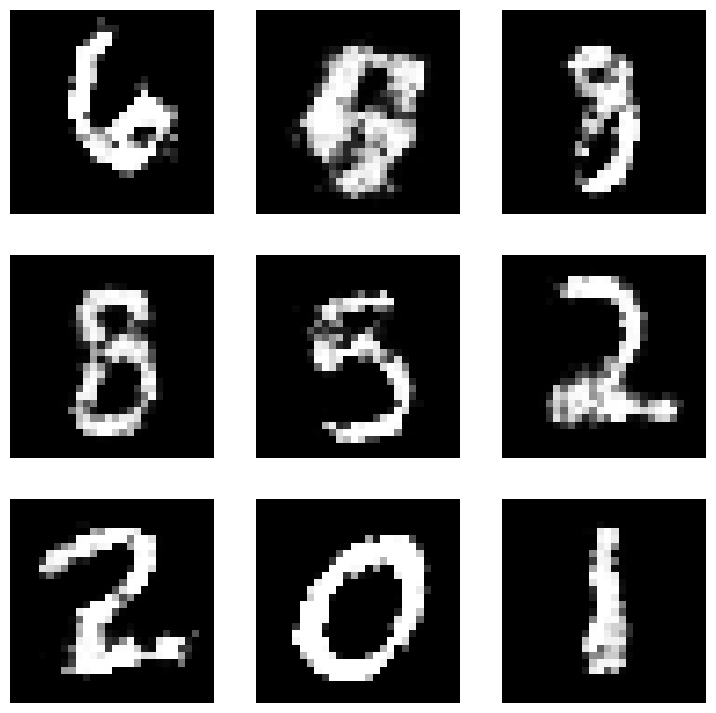

Epoch:   56  AE Loss:    0.020  Gen Loss:    1.123  Dis Loss:    1.105  Total:      2.2


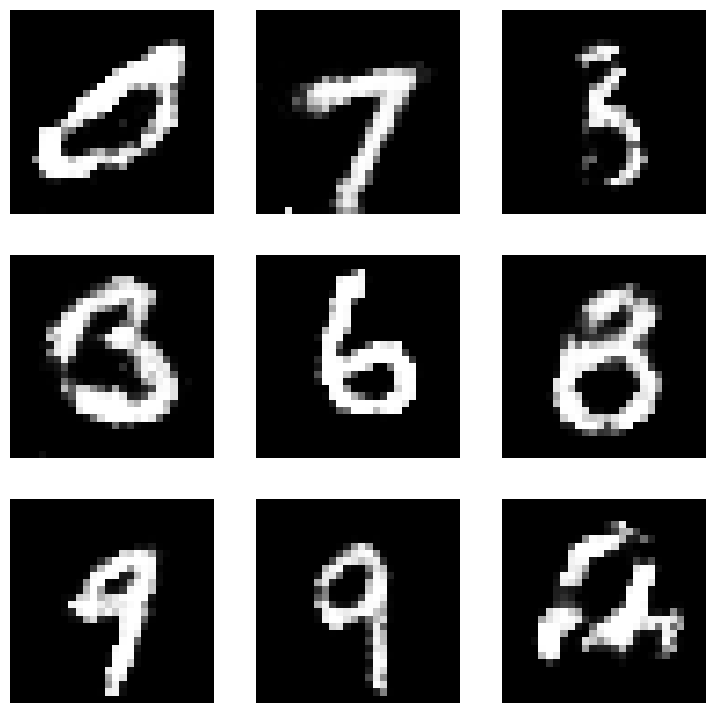

Epoch:   64  AE Loss:    0.019  Gen Loss:    1.162  Dis Loss:    1.075  Total:      2.3


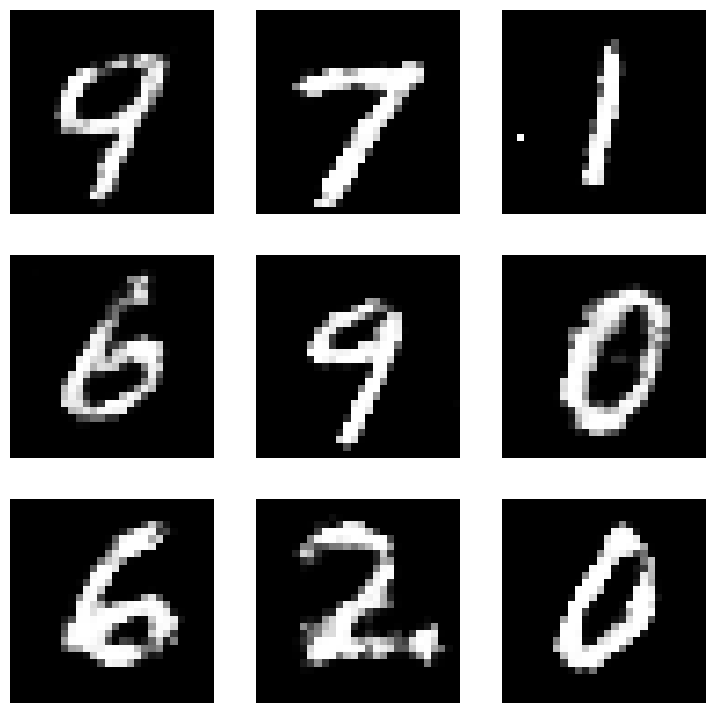

Epoch:   72  AE Loss:    0.018  Gen Loss:    1.236  Dis Loss:    1.047  Total:      2.3


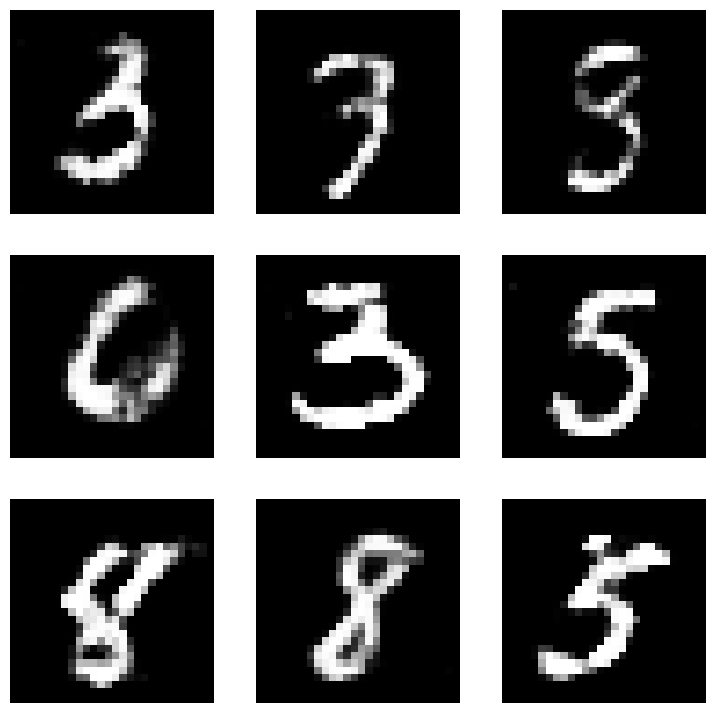

Epoch:   80  AE Loss:    0.018  Gen Loss:    1.299  Dis Loss:    0.991  Total:      2.3


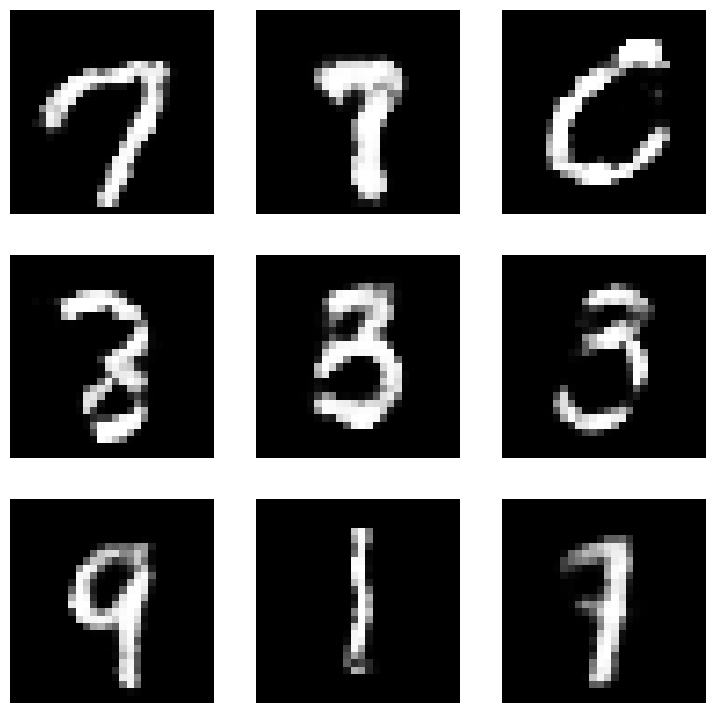

In [83]:
# fix random seed; don't change this
np.random.seed(1)
torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers,
    latent_size=latent_size,
    hidden_size=hidden_size,
    output_size=image_size*image_size,
).to(device)


#optimizers for each network in the model
opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=0.0002)
opt_generator = torch.optim.Adam(model.generator.parameters(), lr=0.0002)
opt_encoder = torch.optim.Adam(model.encoder.parameters(), lr=0.0001)


# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
loss_ae = np.zeros(epochs)

for epoch in range(epochs):
    total_epoch_size = 0

    for batch_idx, batch_data in enumerate(mnist):

        # only run `batch_limit` batches, then end the epoch
        if batch_idx >= batch_limit:
            break

        x_real, y_real = batch_data

        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)





        ########################################################################
        # STEP 1: train the discriminator network to maximize the objective
        #         log(D(x)) + log(1 - D(G(z)))
        ########################################################################

        model.discriminator.zero_grad()

        # train on a batch of real inputs
        y_real = torch.full((n_batch, 1), label_real, device=device)
        preds_real = model.discriminator(x_real)
        loss_real = discrim_loss_func(preds_real, y_real)

        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        #enc = model.encoder(z)
        x_fake = model.generator(z)
        y_fake = torch.full((n_batch, 1), label_fake, device=device)
        preds_fake = model.discriminator(x_fake.detach())  # exclude generator from gradient computation
        loss_fake = discrim_loss_func(preds_fake, y_fake)

        # update discriminator weights
        loss_discriminator = loss_real + loss_fake
        loss_discriminator.backward()
        opt_discriminator.step()

        ########################################################################
        # STEP 2: train the generator network to minimize the objective
        #         log(1 - D(G(z))), or equivalently, to maximize D(G(z))
        ########################################################################
        model.generator.zero_grad()

        # train on a batch of synthesized inputs
        z = torch.randn(n_batch, latent_size).to(device)
        #enc = model.encoder(z)
        x_fake = model.generator(z)
        preds_fake = model.discriminator(x_fake)
        loss_generator = discrim_loss_func(preds_fake, y_real)
        loss_generator.backward()

        # update generator weights
        opt_generator.step()


        #######################################################################
        #Train the autoencoder/decoder
        #######################################################################

        model.encoder.zero_grad()
        model.generator.zero_grad()

        enc = model.encoder(x_real)
        x_fake = model.generator(enc)

        loss_autoencoder = autoencoder_loss_func(x_fake, x_real)
        loss_autoencoder.backward()

        opt_encoder.step()
        opt_generator.step()



        # for name, param in model.generator.named_parameters():
        #     if param.requires_grad:
        #         print(name, param.data)

        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        loss_ae[epoch] += loss_autoencoder.detach().item() * n_batch
        total_epoch_size += n_batch

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size
    loss_ae[epoch] /= total_epoch_size

    if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
        total = loss_ae[epoch] + loss_g[epoch] + loss_d[epoch]
        log = "  ".join([
            f"Epoch: {epoch + 1:4d}",
            f"AE Loss: {loss_ae[epoch]:8.3f}",
            f"Gen Loss: {loss_g[epoch]:8.3f}",
            f"Dis Loss: {loss_d[epoch]:8.3f}",
            f"Total: {total:8.1f}",
        ])
        print(log)
        nrows, ncols = (3, 3)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

        for row in range(nrows):
            for col in range(ncols):
                z = torch.randn(1, latent_size).to(device)
                output = model.generator(z).reshape(image_size, image_size).detach().cpu()
                axes[row, col].imshow(output.squeeze(), cmap='gray')
                axes[row, col].axis('off')

        plt.show()

## Generate new images (3 points)

Once you've trained your model, use this cell to generate images by sampling $z \sim {\mathcal N}(0, 1)$ and producing $G(z)$. We will grade this based on whether your generated images look like the handwritten digits from MNIST. While this is somewhat subjective, here is a rough rubric of how we plan to grade this:

- **0 points**: just blobs or static; no distinction between images

    ![0pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_0pts.png)

- **1 point**: if you squint, it might look like a digit

    ![1pt](https://github.com/cs449f23/lectures/raw/main/static/hw3_1pt.png)

- **2 points**: you can tell what digit each image is supposed to be

    ![2pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_2pts.png)

- **3 points**: you might not be able to tell it apart from an MNIST digit

    ![3pts](https://github.com/cs449f23/lectures/raw/main/static/hw3_3pts.png)

Remember: we must be able to run your notebook from scratch and get similar results.

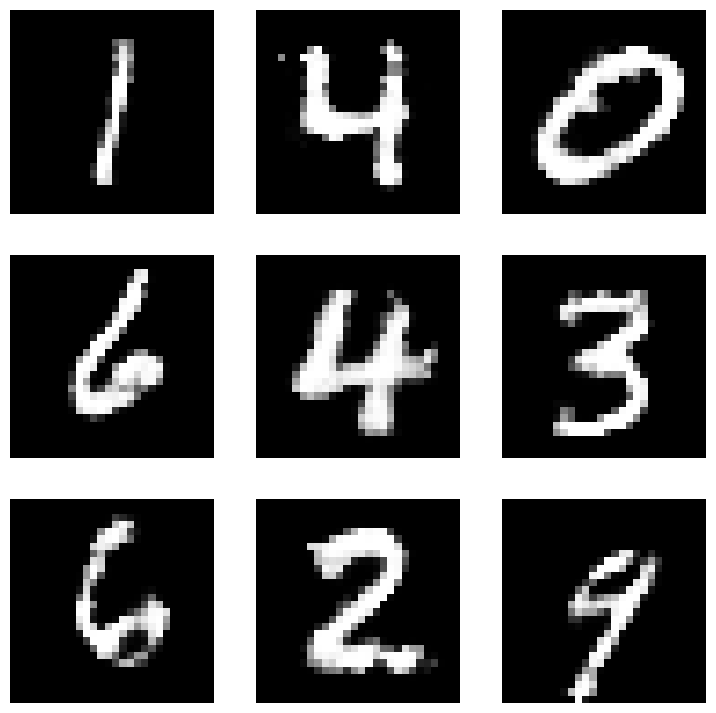

In [88]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        output = model.generator(z).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()

## Auto-encode existing images (1 point)

Once you've trained your model, use this cell to generate images by choosing a random $X$ and generating $G(E(X))$. You should be able to reconstruct images with low reconstruction error; we will grade you based on whether the "Reconstructed Image" looks like the "Original Image".

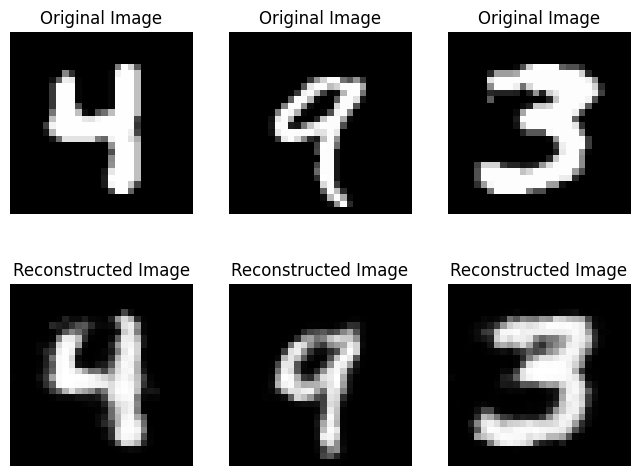

In [91]:
example_batch = next(iter(mnist))[0].to(device)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:3]

for col, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[0, col].imshow(example_image.squeeze(), cmap='gray')
    axes[0, col].set_title("Original Image")
    axes[0, col].axis('off')

    image_input = example_image.flatten().unsqueeze(0).to(device)
    recons_img = model.generator(model.encoder(image_input))
    recons_img = recons_img.reshape(1, image_size, image_size).detach().cpu()
    axes[1, col].imshow(recons_img.squeeze(), cmap='gray')
    axes[1, col].set_title("Reconstructed Image")
    axes[1, col].axis('off')

plt.show()

## Coding explanation (5 points)

### 1. What did you do? (3 points)

Describe your approach in your code above; what choices did you make and why? You should mention:

- What are your loss functions?

- How did you use optimizers to train your model?

- What hyperparameters mattered the most for getting your model to train?

If you weren't able to get the model to train, you can still earn these points by describing what you tried and what didn't seem to work.

### 2. Discuss your results (2 points)

If you were able to get your model to train, what did you notice about the trends in the three different loss values? How do your generated images in the previous cells look similar to or different from the images we saw in the GAN or Autoencoder notebooks? Describe these trends using at least a few sentences.

###1. What did you do?

The training code I wrote trains the models in 3 steps. First the discriminator model is trained. The loss for the discriminator is the sum of the BCE when the discriminator is given real inputs and when it is given inputs created by the generator. The generator model is then trained in two steps. First it is trained based on the GAN loss. For this, the generator creates images and the loss is the BCE of the discriminators predictions of these images. The generator and encoder are then trained together by giving the encoder a real image and then having the generator produce an image based on the encoder's output. The loss for this is the MSE between the real and generated image. Both the encoder and generator are then trained on this loss.



I chose to use a seperate optimzer for each of the models, they are seen below:

opt_discriminator bold text = torch.optim.Adam(model.discriminator.parameters(), lr=0.0002)

opt_generator = torch.optim.Adam(model.generator.parameters(), lr=0.0002)

opt_encoder = torch.optim.Adam(model.encoder.parameters(), lr=0.0001)


The most important hyperparameters for getting the model to train together seemed to be learning rate. Most of my experiments stuck with 80 epochs, 64 batch size, 2x256 model size. Changing the learning rates allowed me to try and correct if one model began to train faster than the others. Additionally the batch limit was important. For running small experiments I used a small batch limit. This limits the amount of data seen during training, so naturally it makes a big impact on performance. My final model used a large batch limit of 1000



###2. Discuss your results

While training the moel, I noticed that the 3 loss values do not really change muchh. The encoder loss usually would start low, (~0.1), and end up around 0.01. The generator loss would start the highest of the three, usually around 2-3, and eventually end up near 1. The discriminator loss would usually start near 1-2, and end near 1-2.

The 3 loss values also tended to interact with eachother in certain ways. The change in the encoder's and generator's loss would most often have the same sign. And the change in the generator's and discriminator's loss would usually have opposite signs. This is expected behavior based on the loss functions that were used.

The images generated by this model look very similar to the ones generated in the GAN notebook. However the reconstructed versions of the images tend to be a bit blurrier compared to the ones in the autoencoder notebook. This might be due to the differences in the decoder/generator model.


## Conceptual questions (5 points)


### 1. Loss functions (2 point)

In the above model that you trained, there should be loss functions for the autoencoder, the generator, and the discriminator. In a standard GAN that just has a generator and discriminator, the two losses are clearly in conflict: the generator is being trained to fool the discriminator, and the discriminator is being trained not to be fooled. Consider the other two pairs of losses in our model; are the losses in conflict?

* a. Are the generator and autoencoder in conflict? That is, if you kept one submodel fixed and trained the other, would reducing the loss of the trained submodel cause the fixed submodel's loss to increase? Why or why not?

* b. Are the discriminator and autoencoder in conflict? That is, if you kept one submodel fixed and trained the other, would reducing the loss of the trained submodel cause the fixed submodel's loss to increase? Why or why not?

### 2. Class conditioning (2 points)

Suppose you wanted to add in class-conditioning to [the generator and discriminator](https://arxiv.org/pdf/1411.1784.pdf) and [the autoencoder](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf) in your model. How would that change the implementation of your model? In particular, let's denote the image $X$ and its label (which digit it is) as $y$. Consider our three submodels as functions: $E(x), G(z), D(x)$. For each, say whether and how $y$ would factor into these models' inputs. Give a one-sentence explanation for each.

* a. Encoder E(X)

* b. Generator G(z)

* c. Discriminator D(X)

### 3. Variational autoencoder (1 points)

Suppose you wanted to make our model more complicated by turning the autoencoder we use above into a variational autoencoder. What would you need to change in terms of model structure and/or loss functions? What might be one benefit of doing this? Provide a 2-3 sentence explanation.

### 1. Loss functions


The generator and encoder are not in conflict. This is due to the fact that the generator's loss shares a term with the encoder's loss, as L(G) = L(GAN) + MSE(X, G(E(X))). The encoder's loss is equal to MSE(X, G(E(X))), so reducing L(G) can only mean reducing or not changing L(E).

The discriminator and generator models are still in conflict for the same reason as before. The two models still have competing goals, so that decreasing the loss for the discriminator makes the generator's job harder, and decreasing the GAN loss of the generator makes the discriminator's job harder. This is also reflected in the training losses recorded from training the models.


### 2. Class conditioning

a. The encoder's input would be changed from E(X) to E(X, y). This would allow the encoder to produce a z in latent space that includes information about the specified class y.

b. The generator's input would remain unchanged, G(Z), where Z is the latent vector produced by the encoder. This input does not need to change because Z should now encode information about the class y.

c. The discriminator's input would change from D(X) to D(X,y). This allows the discriminator to be trained to ensure that the images produced by the generator correctly correspond to the label y.


### 3. Variational autoencoder (1 points)

The loss function of the encoder would need to change so that there is an additional term to regularize the latent space to follow a more normal distribution, this could be KL divergence. Also the encoder outputs would need to be changed to output the mean and variance of the latent space distribution.

Making the encoder a VAE could smooth out the latent space, making it more interpretable easier to sample from. This would also allow for interpolation between points and would make generating images with specific features more feasible.
